In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_li(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

Li atom neutral LDA spin=1
HF
converged SCF energy = -7.43270205121318  <S^2> = 0.75001434  2S+1 = 2.0000143
LDA
converged SCF energy = -7.34320268053483  <S^2> = 0.75000173  2S+1 = 2.0000017


In [7]:
import importlib, recipes, jastrowspin, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, jastrowspin, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=10, nconfig=500, verbose=False)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

Number of determinants in the bosonic wavefunction= 1
Using spherical guess
it 0 ====================
x0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
en -7.656891998737112 en_err 0.16614170743620668
pgrad [0.12024198 0.01968331 0.30637198 0.076499   0.70336286 0.22316036
 1.18049785 0.37618284 0.08769275 0.20308473 0.         0.08147384
 0.4208576  0.         0.0404764  0.58352012 0.        ]
params [array([-0.021818  , -0.00937227, -0.00999782, -0.01708521,  0.12889666,
        0.03023365,  0.47854628,  0.14248879,  0.00516399, -0.00781213,
        0.        ,  0.02164543,  0.03789648,  0.        ,  0.01562219,
        0.14579886,  0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 0.021818  ,  0.00937227,  0.00999782,  0.01708521, -0.12889666,
       -0.03023365, -0.47854628, -0.14248879, -0.00516399,  0.00781213,
        0.        , -0.02164543, -0.03789648,  0.        , -0.01562219,
       -0.14579886,  0.        ]), array([ 0

KeyboardInterrupt: 

In [86]:
tstep = 0.1
nconfig = 100
nblocks = 300
nsteps_per_block = 4
discard = 10

In [15]:
#PYQMC VMC with jastrow
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
nconfig = 500
VMC("scf.hdf5", "vmc-j-001.hdf5",
    load_parameters="sj.hdf5", verbose=False,
    nblocks=nblocks, 
    nsteps_per_block=nsteps_per_block,
    tstep= tstep,
    nconfig=nconfig)

NameError: name 'nblocks' is not defined

Mean  etot_j ,  -14.092392006262537 +/- 0.8951337011213625
Mean  ee_j ,  4.336860765012042 +/- 0.02964974451694474
Mean  ei_j ,  -33.46668122355665 +/- 4.158025434123524
Mean  ke_j ,  15.037428452282063 +/- 6.659595340085532


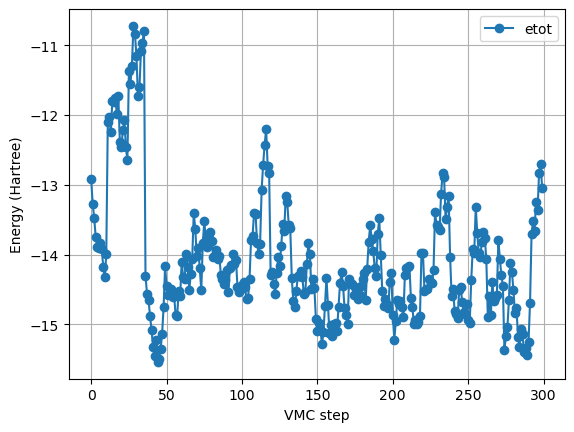

In [66]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
with h5py.File("vmc-j-001.hdf5") as f:
    ee_j = f['energyee'][...]   
    ei_j = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke_j = f['energyke'][...]
    etot_j = f['energytotal'][...]
plt.plot(etot_j, marker='o', label="etot")
# plt.plot(ee_j, marker='o', label="ee")
# plt.plot(ei_j, marker='o', label="ei")
# plt.plot(ke_j, marker='o', label="ke")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.xlim((200,500))
# plt.ylim((-10, 5))
plt.grid()
# plt.figure()
discard = 10
for e in [etot_j, ee_j, ei_j, ke_j]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    print("Mean ", namestr(e, globals())[0], ", ", e_m, "+/-", e_d)

# e_m = np.mean(etot[discard:])
# e_d = np.var(etot[discard:])
# # e_m2 = np.mean(etot2[discard:])
# # e_d2 = np.var(etot2[discard:])
# print("Mean VMC Energy, ", e_m, "+/-", e_d)
# print("LDA Energy, ", mf.energy_tot())
# plt.plot(ed, marker='o', label="ke")

# print('ee', np.mean(ee[discard:]))
# print('ei', np.mean(ei[discard:]))
# print('ke', np.mean(ke[discard:]))


In [89]:
#ABVMC with jastrows
#
#
import importlib, multiplywf, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

ABVMC("scf.hdf5", "abvmc-j-001.hdf5", 
      load_parameters="sj.hdf5", verbose=True,  
      nblocks=nblocks, 
      nsteps_per_block=nsteps_per_block,
      tstep= tstep, 
      nconfig=nconfig)

Number of determinants in the bosonic wavefunction= 1
Using spherical guess
-> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/jastrowspin.py(911)gradient_laplacian()
    909         import pdb
    910         pdb.set_trace()
--> 911         return gpu.asnumpy(grad), gpu.asnumpy(lap + gpu.cp.sum(grad**2, axis=0))
    912 
    913     def pgradient(self):



ipdb>  grad.shape


(3, 100)


ipdb>  gpu.cp.sum(grad**2, axis=0).shape


(100,)


ipdb>  exit


Mean  etot_j_abvmc ,  -7.58366150233924 +/- 0.05046229621105134
LDA Energy,  -7.34320268053483


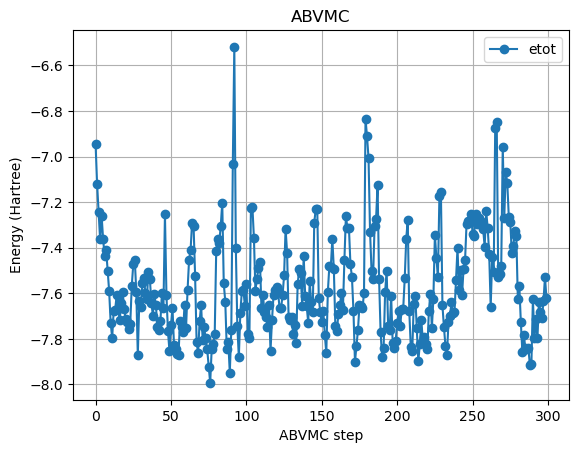

In [88]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-j-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_j_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc

plt.plot(etot_j_abvmc, marker='o', label="etot")

plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_j_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
print("LDA Energy, ", mf_lda.energy_tot())



Mean  etot_j_abvmc ,  -10.385957831740832 +/- 1.076490875239629
LDA Energy,  -7.34320268053483


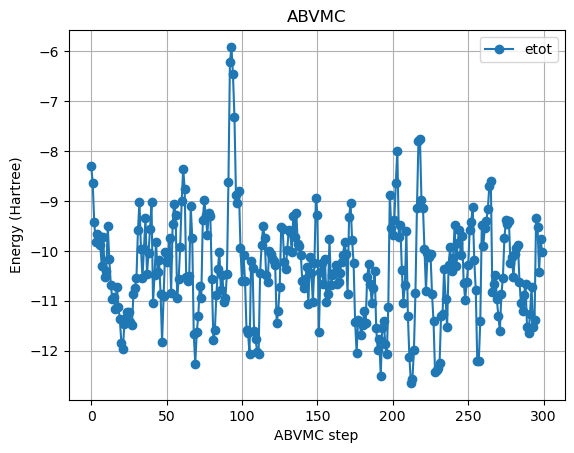

In [84]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-j-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_j_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc

plt.plot(etot_j_abvmc, marker='o', label="etot")

plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_j_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
print("LDA Energy, ", mf_lda.energy_tot())



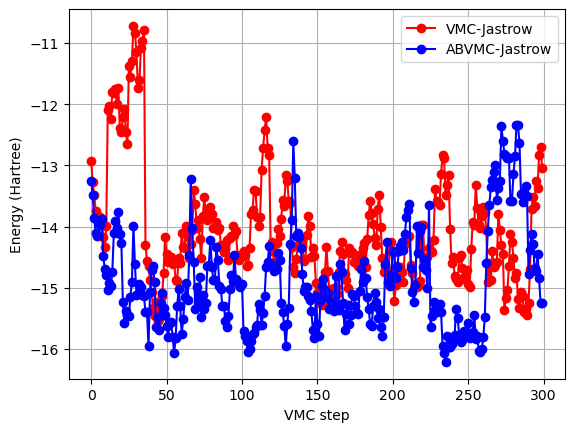

In [69]:
plt.plot(etot_j, marker='o', color = 'r', label="VMC-Jastrow")
plt.plot(etot_j_abvmc, marker='o', color='b', label="ABVMC-Jastrow")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
# discard =  1000
# plt.axvline(discard, linestyle='dashed')
# plt.axhline(np.mean(etot_j[discard:]), color='r')
# plt.axhline(np.mean(etot_j_abvmc[discard:]), color='b')
plt.grid()
